# Step 1: Install Requirements

In [ ]:
!pip install skyfield
!pip install tzwhere
!pip install geopy
!pip install matplotlib
!pip install timezonefinder
!pip install scikit-learn
!pip install plotly

from datetime import datetime
from geopy import Nominatim
from tzwhere import tzwhere
from pytz import timezone, utc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle

from skyfield.api import Star, load, wgs84
from skyfield.data import hipparcos
from skyfield.projections import build_stereographic_projection
from timezonefinder import TimezoneFinder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.0/367.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tzwhere: filename=tzwhere-3.0.3-py3-none-any.whl size=23742580 sha256=a2c79df82d8e3f547a5f23015ccbdc79c4dc7b7b2fad9f8f653de4fb110c9aab
  Stored in directory: /root/.cache/pip/wheels/09/8a/71/9ba6bbc3e1a7e468df19fc8e6c5b70feabb5b06260da8addc0
Successfully built tzwhere
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00


In [ ]:
# load celestial data

# de421 shows position of earth and sun in space
eph = load('de421.bsp')

# hipparcos dataset contains star location data
with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

[#################################] 100% de421.bsp
[#################################] 100% hip_main.dat


# Step 2: Data Collection

## 2.1 Define Model Training Data

In [ ]:
# Our model will be trained using images from the following locations, dates,
# and specific local time. Our deliverable will include a map of predicted
# location(s) that our model will output.

LOCATIONS = [
    ("Seattle", "WA"),
    ("San Francisco", "CA"),
    ("San Diego", "CA"),
    ("Salt Lake City", "UT"),
    ("Denver", "CO"),
    ("Albuquerque", "NM"),
    ("Phoenix", "AZ"),
    ("Dallas", "TX"),
    ("Minneapolis", "MN"),
    ("Chicago", "IL"),
    ("St. Louis", "MO"),
    ("Atlanta", "GA"),
    ("New Orleans", "LA"),
    ("Tampa", "FL"),
    ("Charlotte", "NC"),
    ("Washington", "DC"),
    ("Pittsburgh", "PA"),
    ("New York City", "NY"),
    ("Boston", "MA"),
    ("Great Falls", "MT"),
    ("Salina", "KS"),
    ("North Platte", "NE"),
    ("Cody", "WY"),
    ("Williston", "ND"),
    ("Pierre", "SD"),
    ("Laredo", "TX"),
    ("Redmond", "OR"),
    ("El Paso", "TX"),
    ("Jonesboro", "AR"),
    ("Austin", "NV"),
    ("Honolulu", "HI"),
    ("Anchorage", "AK")
]


print(f'Locations: {len(LOCATIONS)}')

Locations: 32


In [ ]:
import plotly.express as px
import pandas as pd

# City data with known lat/lon
city_data = [
    ("Seattle", "Washington", 47.6062, -122.3321),
    ("San Francisco", "California", 37.7749, -122.4194),
    ("San Diego", "California", 32.7157, -117.1611),
    ("Salt Lake City", "Utah", 40.7608, -111.8910),
    ("Denver", "Colorado", 39.7392, -104.9903),
    ("Albuquerque", "New Mexico", 35.0844, -106.6504),
    ("Phoenix", "Arizona", 33.4484, -112.0740),
    ("Dallas", "Texas", 32.7767, -96.7970),
    ("Minneapolis", "Minnesota", 44.9778, -93.2650),
    ("Chicago", "Illinois", 41.8781, -87.6298),
    ("St. Louis", "Missouri", 38.6270, -90.1994),
    ("Atlanta", "Georgia", 33.7490, -84.3880),
    ("New Orleans", "Louisiana", 29.9511, -90.0715),
    ("Tampa", "Florida", 27.9506, -82.4572),
    ("Charlotte", "North Carolina", 35.2271, -80.8431),
    ("Washington", "District of Columbia", 38.9072, -77.0369),
    ("Pittsburgh", "Pennsylvania", 40.4406, -79.9959),
    ("New York City", "New York", 40.7128, -74.0060),
    ("Boston", "Massachusetts", 42.3601, -71.0589),
    ("Great Falls", "Montana", 47.5065, -111.3008),         # Central Montana
    ("Salina", "Kansas", 38.8403, -97.6114),                # North-central Kansas
    ("North Platte", "Nebraska", 41.1403, -100.7601),        # South of South Dakota, Western Nebraska
    ("Cody", "Wyoming", 44.5263, -109.0565),             # Northwest Wyoming (near Yellowstone)
    ("Williston", "North Dakota", 48.1469, -103.6170),    # Northern North Dakota (oil boom region, near Canada)
    ("Pierre", "South Dakota", 44.3683, -100.3509),
    ("Laredo", "Texas", 27.5306, -99.4803),
    ("Redmond", "Oregon", 44.2726, -121.1739),
    ("El Paso", "Texas", 31.7619, -106.4850),
    ("Jonesboro", "Arkansas", 35.8423, -90.7043),
    ("Austin", "Nevada", 39.4955, -117.0679),
    ("Honolulu", "Hawaii", 21.3069, -157.8583),
    ("Anchorage", "Alaska", 61.2181, -149.9003)

]

# Create DataFrame
df = pd.DataFrame(city_data, columns=["City", "State", "Latitude", "Longitude"])

# Add combined label for hover
df["Label"] = df["City"] + ", " + df["State"]

# Create Plotly map
fig = px.scatter_geo(
    df,
    lat="Latitude",
    lon="Longitude",
    text="City",  # Shows city name on plot
    hover_name="Label",
    projection="albers usa",
    scope="usa",
)


fig.update_traces(marker=dict(size=8, color="red"))
fig.update_traces(textposition="middle right")
fig.update_layout(
    title="30 Evenly Spread Continental U.S. Cities + Honolulu, HI and Anchorage, AK",
    margin=dict(l=0, r=0, t=40, b=0),
)

# move the names of cities above marker labels



fig.show()


## 2.2 Processing Star and Sky Data

`render_star_image`

This function produces clean synthetic sky images based on location, date and time.

In [ ]:
# Credits to Viyaleta Apgar
# URL: https://viyaleta.medium.com/how-to-make-a-sky-map-in-python-a362bf722bb2
#
# This function is an additional

# Adapted from Viyaleta Apgars's implementation of Sky Maps
# Article: https://viyaleta.medium.com/how-to-make-a-sky-map-in-python-a362bf722bb2
# Source code: https://github.com/viyaleta/Python-Demos/blob/main/Sky%20Map%20Demo.ipynb
#
# Modifications by Sebastian Ashcallay:
# - Save feature (local) for iterative use
# - Specifications on location, date, and time



def render_star_image(city: str, state: str, date: str, time: str, save_path: str):
  '''
  Generate a stereographic night sky image and save it to the specified path.

  Args:
    city (str): The name of the city.
    state (str): The state or region of the city.
    date (str): The date in the format 'YYYY-MM-DD'.
    time (str): The time in the format 'HH:MM:SS'.
    save_path (str): The path to save the generated image.

  Returns:
    None
  '''

  # Get latitude and longitude of our location
  locator = Nominatim(user_agent='myGeocoder')
  location = locator.geocode(f'{city},{state}')
  lat, lng = location.latitude, location.longitude

  # Convert date string into datetime object
  dt = datetime.strptime(f'{date} {time}', '%Y-%m-%d %H:%M:%S')

  # Define datetime and convert to utc based on our timezone
  tf = TimezoneFinder()
  timezone_str = tf.timezone_at(lat=lat, lng=lng)
  local = timezone(timezone_str)

  # Get UTC from local timezone and datetime
  local_dt = local.localize(dt, is_dst=None)
  utc_dt = local_dt.astimezone(utc)

  # Find location of earth and sun and set the observer position
  sun = eph['sun']
  earth = eph['earth']

  # Define observation time from our UTC datetime
  ts = load.timescale()
  t = ts.from_datetime(utc_dt)

  # Define an observer using the world geodetic system data
  observer = wgs84.latlon(latitude_degrees=lat, longitude_degrees=lng).at(t)

  # Define the position in the sky where we will be looking
  position = observer.from_altaz(alt_degrees=90, az_degrees=0)

  # Center the observation point in the middle of the sky
  ra, dec, distance = observer.radec()
  center_object = Star(ra=ra, dec=dec)

  # Find where our center object is relative to earth and build a projection
  # with 180 degree view
  center = earth.at(t).observe(center_object)
  projection = build_stereographic_projection(center)
  field_of_view_degrees = 180.0

  # Calculate star positions and project them onto a plain space
  star_positions = earth.at(t).observe(Star.from_dataframe(stars))
  stars['x'], stars['y'] = projection(star_positions)

  # Plot the images
  chart_size = 10
  max_star_size = 100
  limiting_magnitude = 10

  bright_stars = (stars.magnitude <= limiting_magnitude)
  magnitude = stars['magnitude'][bright_stars]

  fig, ax = plt.subplots(figsize=(chart_size, chart_size))
  border = plt.Circle((0,0), 1, color= 'navy', fill=True)
  ax.add_patch(border)
  marker_size = max_star_size * 10 ** (magnitude / -2.5)
  ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
             s=marker_size, color='white', marker='.', linewidths=0,
             zorder=2)
  horizon = Circle((0,0), radius=1, transform=ax.transData)
  for col in ax.collections:
    col.set_clip_path(horizon)

  # Additional settings
  ax.set_xlim(-1,1)
  ax.set_ylim(-1,1)
  ax.axis('off')

  # Save image
  plt.savefig(save_path)
  plt.close()


In [ ]:
## EXAMPLE ##
test_city = 'San Francisco'
test_state = 'CA'
test_date = '2024-01-15'
test_time = '22:00:00'
test_save_path = '/content/test_image.png'

render_star_image(test_city, test_state, test_date, test_time, test_save_path)

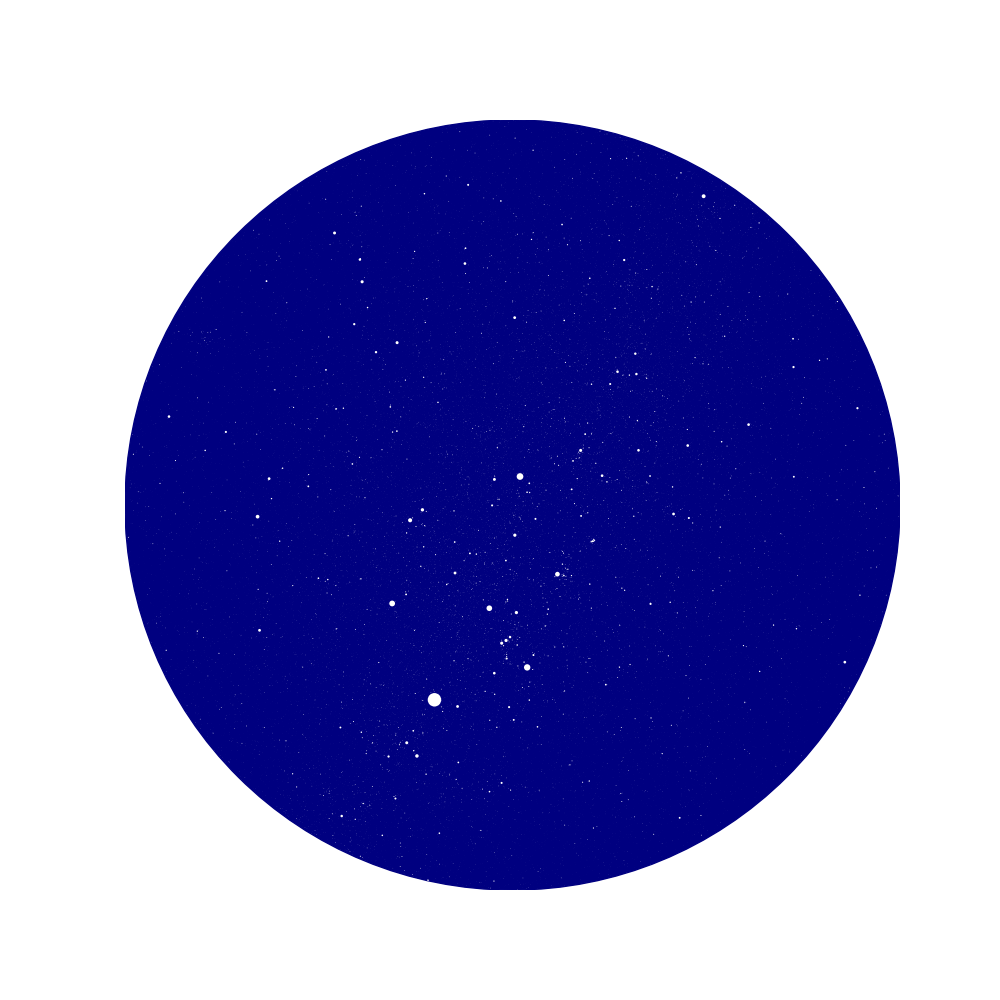

In [ ]:
# View image created
from PIL import Image

Image.open(test_save_path)

`augment_star_image_with_mask`

This function applies different types of visual distortions to our image at random, simulating real-life vision of the sky. We use a mask to only apply these distortions to the sky projection.

In [ ]:
from string import hexdigits
from PIL import Image, ImageEnhance, ImageFilter, ImageDraw, ImageFont
import random
import numpy as np
import os

def augment_star_image_with_mask(input_path, output_path, augmentations):
    """
    Apply visual distortions to simulate real-world variability.

    Args:
      input_path (str): path to a clean rendered sky image
      output_path (str): where to save the augmented image
      augmentations (dict): dict of augmentations to apply to the image. Example:

        {
          'clouds': True,
          'blur': True,
          'light_pollution': True,
        }
    """

    # Load image
    img = Image.open(input_path).convert('RGB')
    width, height = img.size
    center_x, center_y = 510,505
    radius = 385

    # Create circular mask
    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((center_x - radius, center_y - radius,
                  center_x + radius, center_y + radius), fill=255)
    mask_np = np.array(mask) / 255.0  # Normalize mask to [0, 1]

    # Convert image to numpy for selective modification
    img_np = np.array(img)

    def apply_inside_mask(base, effect_fn):
        base_copy = base.copy()
        effected = effect_fn(Image.fromarray(base_copy))
        effected_np = np.array(effected)
        return (effected_np * mask_np[..., None] + base_copy * (1 - mask_np[..., None])).astype(np.uint8)

    # === Apply Augmentations ===

    if augmentations.get('clouds', False):
        def clouds_effect(im):
            overlay = Image.new('RGBA', im.size, (0, 0, 0, 0))
            draw = ImageDraw.Draw(overlay)
            for _ in range(10):
                x, y = random.randint(0, width), random.randint(0, height)
                r = random.randint(20, 60)
                draw.ellipse((x - r, y - r, x + r, y + r), fill=(255, 255, 255, random.randint(40, 100)))
            return Image.alpha_composite(im.convert('RGBA'), overlay).convert('RGB')

        img_np = apply_inside_mask(img_np, clouds_effect)

    if augmentations.get('blur', False):
        def blur_effect(im):
            return im.filter(ImageFilter.GaussianBlur(radius=1.5))
        img_np = apply_inside_mask(img_np, blur_effect)

    if augmentations.get('light_pollution', False):
        def pollution_effect(im):
            overlay = Image.new('RGB', im.size, (0, 0, 0))
            draw = ImageDraw.Draw(overlay)
            for r in range(radius, 0, -5):
                color = int(255 * (1 - r / radius))
                draw.ellipse((center_x - r, center_y - r, center_x + r, center_y + r),
                             fill=(color, color // 2, 0))  # Warm glow
            return Image.blend(im, overlay, alpha=0.3)

        img_np = apply_inside_mask(img_np, pollution_effect)

    # Final compositing: restore white background outside circle
    final_img = Image.fromarray(img_np)
    bg = Image.new("RGB", (width, height), (255, 255, 255))
    final_img = Image.composite(final_img, bg, mask)

    # Save result
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    final_img.save(output_path)



In [ ]:
## EXAMPLE ##
input_path = '/content/test_image.png'
output_path = '/content/test_image_augmented.png'
filters = {
    'clouds': True,
    'blur': True,
    'light_pollution': True,
}

augment_star_image_with_mask(input_path, output_path, filters)


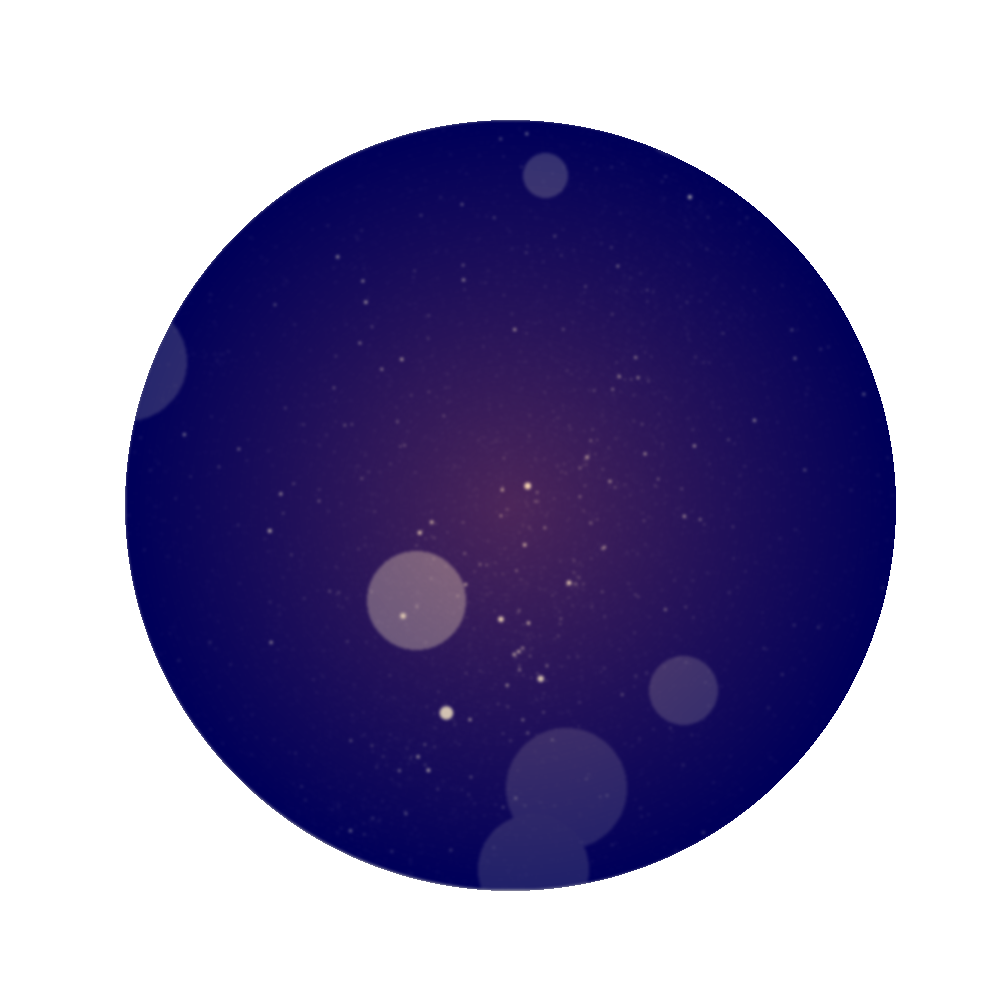

In [ ]:
# View augmented image created
from PIL import Image

Image.open(output_path)

## 2.3 Building Our Dataset

`build_star_dataset`

This function acts as a full dataset generator for our model's training data.


---

Our dataset will be saved in organized folders:
```python
dataset_clean/
├── Seattle_WA/
│   └── Seattle_WA_2024-01-15.png
dataset_augmented/
├── Seattle_WA/
│   ├── Seattle_WA_2024-01-15_aug1.png
│   ├── Seattle_WA_2024-01-15_aug2.png
│   └── Seattle_WA_2024-01-15_aug3.png


```

In [ ]:
import os

def build_star_dataset(
    locations, dates, times, num_augmentations,
    clean_dir, augmented_dir,
    render_star_image_func,
    augment_star_image_func
):
    """
    Build dataset with clean and augmented star images.

    Automatically creates subdirectories for each city/state.

    Args:
      locations: list of (city, state)
      dates: list of YYYY-MM-DD strings
      time: string, e.g., "22:00:00"
      num_augmentations: how many augmented versions per image
      clean_dir: directory to save clean renders
      augmented_dir: directory to save augmented images
      render_star_image_func: function to render clean images
      augment_star_image_func: function to apply augmentations
    """
    for city, state in locations:
        label = f"{city}_{state}"
        clean_subdir = os.path.join(clean_dir, label)
        aug_subdir = os.path.join(augmented_dir, label)

        os.makedirs(clean_subdir, exist_ok=True)
        os.makedirs(aug_subdir, exist_ok=True)

        for date in dates:
            for time in times:
                timestamp = f"{date}_{time.replace(':', '-')}"  # e.g. "2024-03-15_22-00-00"
                filename = f"{label}_{timestamp}.png"
                clean_path = os.path.join(clean_subdir, filename)

                # Step 1: Generate clean image
                render_star_image_func(city, state, date, time, clean_path)

                # Step 2: Generate augmented versions
                for i in range(num_augmentations):
                    aug_filename = f"{label}_{timestamp}_aug{i+1}.png"
                    aug_path = os.path.join(aug_subdir, aug_filename)

                    augmentations = {
                        'clouds': bool(i % 4 == 0),
                        'blur': bool(i % 2 == 0),
                        'light_pollution': bool(i % 3 == 0)
                    }

                    augment_star_image_func(clean_path, aug_path, augmentations)


In [ ]:
## EXAMPLE ##

# Disclaimer: These next produced images are just to see if the local files are
# correctly or not

test_locations = [("Seattle", "WA"),("Miami", "FL")]
test_dates = ["2024-01-15", "2024-03-15"]
test_times = ["22:00:00"]
test_num_augmentations = 3
test_clean_dir = "dataset_clean"
test_augmented_dir = "dataset_augmented"

build_star_dataset(
    locations=test_locations,
    dates=test_dates,
    time=test_times,
    num_augmentations=test_num_augmentations,
    clean_dir=test_clean_dir,
    augmented_dir=test_augmented_dir,
    render_star_image_func=render_star_image,
    augment_star_image_func=augment_star_image_with_mask
)


radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)
radius of mask: 385
center of mask: (510, 505)


In [ ]:
# Delete folders: 'dataset_clean' and 'dataset augmented' after example run
!rm -rf /content/dataset_clean
!rm -rf /content/dataset_augmented

In [ ]:
# Run the dataset generation again with restored environment
dates = ["2024-06-06"]
times = [
    "19:00:00",
    "20:00:00",
    "21:00:00",
    "22:00:00",
    "23:00:00",
    "00:00:00",
    "01:00:00",
    "02:00:00",
    "03:00:00",
    "04:00:00",
    "05:00:00",
    "06:00:00",
]

build_star_dataset(
    locations=LOCATIONS,
    dates=dates,
    times=times,
    num_augmentations=5,
    clean_dir="/content/dataset_clean",
    augmented_dir="/content/dataset_augmented",
    render_star_image_func=render_star_image,
    augment_star_image_func=augment_star_image_with_mask
)

In [ ]:
# Check number of files in dataset_augmented and subfolders
!find /content/dataset_augmented -type f | wc -l

1920


# Step 3: Training Our Classification Model


## 3.1 Setup Process

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

!pip uninstall scikit-learn numpy -y
!pip install numpy==2.0.2 scikit-learn

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 63.6 MB/s eta 0:00:00


In [ ]:
# Replace with your actual path
DATASET_DIR = "dataset_augmented"

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Load dataset
full_dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

# Train/val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## 3.2 ResNet18 (Transfer Learning)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)

# Freeze earlier layers (optional)
# for param in resnet.parameters():
#     param.requires_grad = False

# Replace final layer
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet = resnet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 52.6MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0005)

def train_resnet(model, train_loader, val_loader, epochs=5, device='cpu'):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

        # Validation Accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f"Validation Accuracy: {100 * correct / total:.2f}%")

    return model


In [ ]:
model = train_resnet(resnet, train_loader, val_loader, epochs=10, device=device)


Epoch 1 - Loss: 171.1657
Validation Accuracy: 2.60%
Epoch 2 - Loss: 163.6510
Validation Accuracy: 6.25%
Epoch 3 - Loss: 115.3498
Validation Accuracy: 19.53%
Epoch 4 - Loss: 75.4749
Validation Accuracy: 30.99%
Epoch 5 - Loss: 48.7941
Validation Accuracy: 48.44%
Epoch 6 - Loss: 26.2371
Validation Accuracy: 58.07%
Epoch 7 - Loss: 13.9833
Validation Accuracy: 91.67%
Epoch 8 - Loss: 7.2484
Validation Accuracy: 79.95%
Epoch 9 - Loss: 5.9325
Validation Accuracy: 92.19%
Epoch 10 - Loss: 5.8736
Validation Accuracy: 84.38%


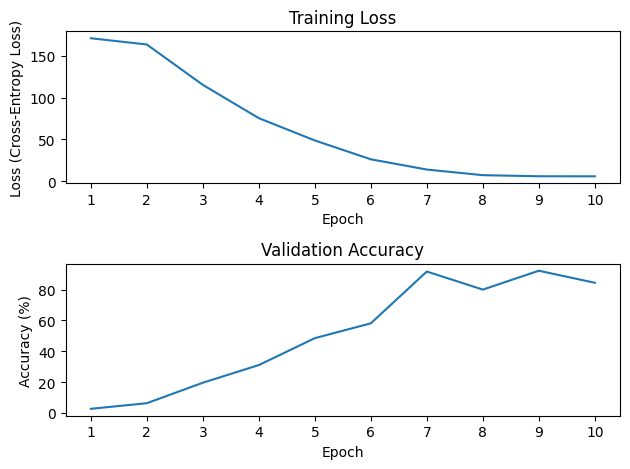

In [ ]:
val_loss = [
    171.1657,
    163.6510,
    115.3498,
    75.4749,
    48.7941,
    26.2371,
    13.9833,
    7.2484,
    5.9325,
    5.8736
]

acc = [
    2.6,
    6.25,
    19.53,
    30.99,
    48.44,
    58.07,
    91.67,
    79.95,
    92.19,
    84.38
]

# graph the val_loss and acc on two separate plots
fig, axs = plt.subplots(2, 1)
xvals = np.arange(1, len(val_loss)+1, 1)
axs[0].plot(xvals, val_loss)
axs[0].set_title('Training Loss')
axs[0].set_ylabel('Loss (Cross-Entropy Loss)')
axs[0].set_xlabel('Epoch')
#xticks spaced 1 apart
axs[0].set_xticks(xvals)
axs[1].plot(xvals, acc)
axs[1].set_title('Validation Accuracy')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_xlabel('Epoch')
#xticks spaced 1 apart
axs[1].set_xticks(xvals)
plt.tight_layout()
plt.show()


# Step 4: Evaluation

## 4.1 Confusion Matrix

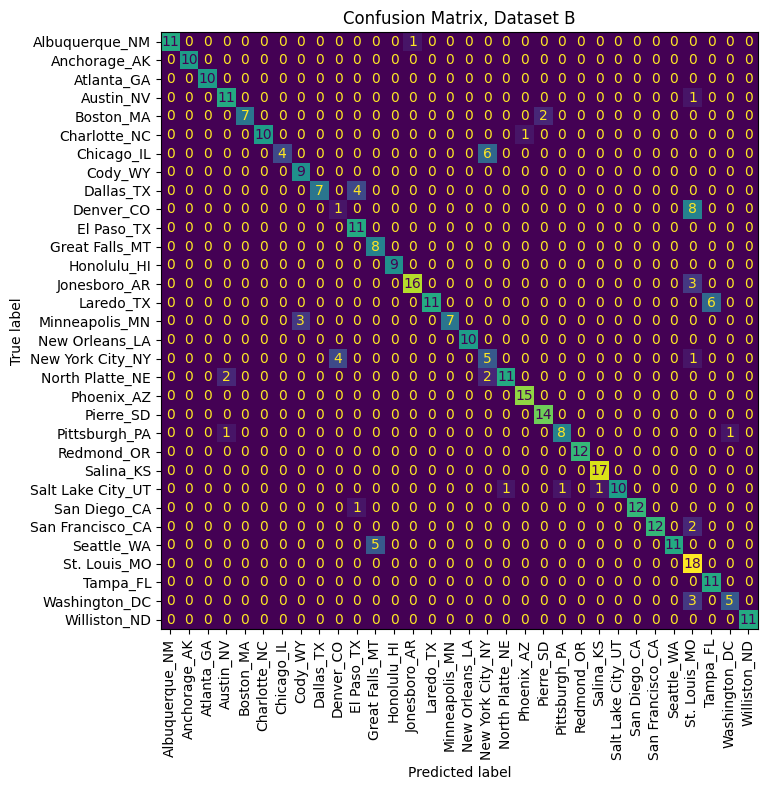

In [ ]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot
unique_labels = np.unique(np.concatenate([y_true, y_pred]))
label_names = [class_names[i] for i in unique_labels]
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=ax, xticks_rotation=90, cmap="viridis", colorbar=False)
plt.title("Confusion Matrix, Dataset B")
plt.tight_layout()
plt.show()


## 4.2 Classification Report

In [ ]:
from sklearn.metrics import classification_report
# print sklearn with greater precision
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))


                   precision    recall  f1-score   support

   Albuquerque_NM     1.0000    0.9167    0.9565        12
     Anchorage_AK     1.0000    1.0000    1.0000        10
       Atlanta_GA     1.0000    1.0000    1.0000        10
        Austin_NV     0.7857    0.9167    0.8462        12
        Boston_MA     1.0000    0.7778    0.8750         9
     Charlotte_NC     1.0000    0.9091    0.9524        11
       Chicago_IL     1.0000    0.4000    0.5714        10
          Cody_WY     0.7500    1.0000    0.8571         9
        Dallas_TX     1.0000    0.6364    0.7778        11
        Denver_CO     0.2000    0.1111    0.1429         9
       El Paso_TX     0.6875    1.0000    0.8148        11
   Great Falls_MT     0.6154    1.0000    0.7619         8
      Honolulu_HI     1.0000    1.0000    1.0000         9
     Jonesboro_AR     0.9412    0.8421    0.8889        19
        Laredo_TX     1.0000    0.6471    0.7857        17
   Minneapolis_MN     1.0000    0.7000    0.8235       

## 4.3 Top-3 Accuracy

In [ ]:
from torch.nn.functional import softmax

def evaluate_top_k(model, dataloader, k=3):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = softmax(outputs, dim=1)
            topk = torch.topk(probs, k=k, dim=1).indices
            correct += sum(labels[i] in topk[i] for i in range(labels.size(0)))
            total += labels.size(0)
    print(f"Top-{k} Accuracy: {100 * correct / total:.2f}%")

evaluate_top_k(model, val_loader, k=3)


Top-3 Accuracy: 99.74%


## 4.4 Predicting an Image

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

def predict_image(image_path, model, class_names, device='cpu'):
    """
    Predict the most likely locations for a given sky image.

    Parameters:
    - image_path (str): Path to the image file
    - model (torch.nn.Module): Trained PyTorch model
    - class_names (List[str]): List of label names
    - device (str): 'cpu' or 'cuda'

    Prints the top 5 predictions with confidence scores.
    """
    model.eval()

    # Use the same transforms as training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        top5 = torch.topk(probs, 5)

    #print(f"Top 3 predictions for image: {image_path}")

    predictions = []

    for i in range(3):
        city = class_names[top5.indices[i]]
        score = top5.values[i].item()
        #print(f"{i+1}. {city}: {score:.4f}")
        predictions.append((city,score))

    return predictions


In [ ]:
# Example usage


# Step 1: Generate rendered image
test_city = 'College Park'
test_state = 'MD'
test_date = '2024-06-06'
test_time = '22:00:00'
test_save_path = '/content/test_image.png'

render_star_image(test_city, test_state, test_date, test_time, test_save_path)

# Step 2: Augment image
test_augmentations = {
    'clouds': True,
    'blur': True,
    'light_pollution': True,
}

test_save_aug_path = '/content/test_image_augmented.png'
augment_star_image_with_mask(test_save_path, test_save_aug_path, test_augmentations)

# Step 3: Generate prediction
count = 0
actual_city = 'Washington_DC'
for i in range(100):
  predictions = predict_image(test_save_aug_path, model, class_names, device=device)
  max_score = 0
  max_score_idx = 0
  for i,prediction in enumerate(predictions):
    if max_score < prediction[1]:
      max_score = prediction[1]
      max_score_idx = i

  if actual_city in predictions[max_score_idx][0]:
    count += 1



print(f'Out of 100 attempts, our model predicted College Park to be close to {actual_city} {count} times')


Out of 100 attempts, our model predicted College Park to be close to Washington_DC 100 times
